In [8]:
%pip install -Uqq fastai duckduckgo-search

Note: you may need to restart the kernel to use updated packages.


### Данные

1. Нам нужны данные в большом виде, в данном примере у нас есть лимит на 100 картинок в ddg поиске
2. Скачиваем данные по каждому классу классификации. **Кол-во данных должно приближаться к 100+**. В примере с Дотой, когда были все классы и 20 картинок на класс, **error_rate=0.7**

In [9]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url

charracters_array = [
    'lion',
    'pudge',
    'axe',
    'lina',
    'tinker',
    # 'slark',
    'invoker',
    'zeus',
    # 'drow',
    'sniper',
    'mirana',
    'windranger',
    # 'phantom assassin',
    # 'templar assassin',
    'viper',
    'luna',
    # 'dazzle',
    # 'phantom lancer',
    # 'juggernaut',
    'bloodseeker',
    'riki',
    'clinkz',
    'weaver',
    # 'spectre',
]

for character in charracters_array:
    try:
        images = ddg_images(character + " dota2 photo", max_results=100)
        for idx, image in enumerate(images): 
            try:
                download_url(image['image'], Path('images')/f"{character}_{idx}.jpg", show_progress=False)
            except Exception as e:    
                print(f"Error on {character}_{idx}.jpg")
                print(e)
    except Exception as e:
        print(f"Error on {character}")
        print(e)    

/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


KeyboardInterrupt: 

### Чистим данные

Чистим данные: избавляемся от битых картинок

In [20]:
import os
from PIL import Image

def is_image_corrupted(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # verify that it is, in fact an image
        # делаем to_thumb для нашего сайза, была ошибка которая на следующем этапе ломалась если не сделать
        # `OSError(\nOSError: image file is truncated (23 bytes not processed)\n`
        Image.open(image_path).to_thumb(460, 460)
        return False
    except (IOError, SyntaxError) as e:
        return True

def clean_dataset(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if is_image_corrupted(file_path):
            print(f"Corrupted image detected and removed: {file_path}")
            os.remove(file_path)

clean_dataset('images')

Corrupted image detected and removed: images/lion_17.jpg


### Подготовка к обучению

1. Нам нужна data (картинки) **X** asix
2. Нам нужны лейблы (классы: axe, pudge) **Y** asix

In [5]:
from fastai.vision.all import *
# y
def label_func(title): return title.split("_")[0]

# x
path = Path('images')
files = get_image_files(path)
len(files)

1371

Созадем **dataloaders**

Класс, в который мы прокидываем labels, data, transform function (нужна чтобы сделать все картинки одного размера 224) и batch_tfms, трансформ для батча. Нужен когда у нас более сложная задачка. Классификация нескольких классов например

`item_tfms=Resize(460), batch_tfms=aug_transforms(size=224)`

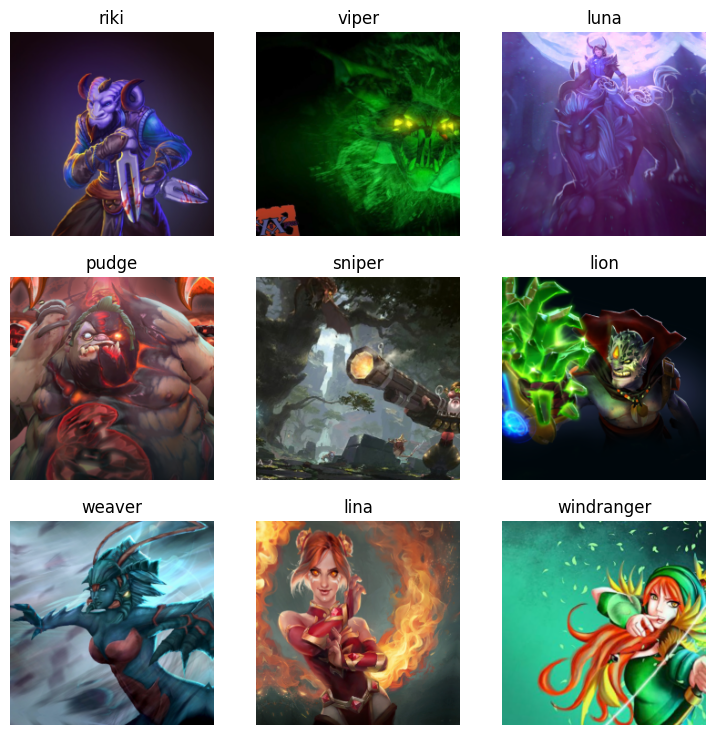

In [8]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize((460)), 
                                      batch_tfms=aug_transforms(size=(224)), method=ResizeMethod.Crop)

dls.show_batch()

### Обучение

Создаем learner
1.  Прокидываем dls(dataloaders)
2.  Выбираем модель resnet18/resnet34/resnet50/resnet/101 
3.  Прокидываем metrics=error_rate

Про выбор моделей

https://huggingface.co/models?pipeline_tag=image-classification&sort=trending

>Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should b

SuggestedLRs(valley=0.0020892962347716093)

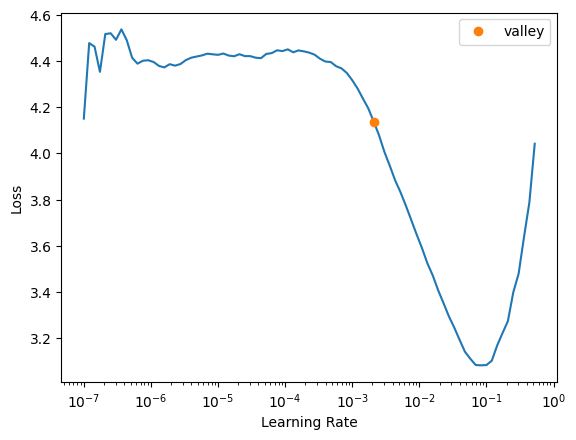

In [14]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

# используем для того чтобы найти оптимальный learning rate, который используем для второго параметра в fine_tune
learn.lr_find()

### Обучаем модель

`learn.fine_tune(3, 0.001737800776027143)`

Принимает 2 параметра — кол-во epoch (эпох/циклов). Сколько раз нужно обучать
Второй какую-то штуку, от которой будет зависеть скорость и точность обучения. ее надо вычсчитывать с помощью код блока вверху, и посдавлять сюда.

В итоге появится табличка, в которой будут отображены некоторые параметры

**error_rate** — самый важный параметр, от 0 до 1. Отвечает за результат нашей модели на валидационных данных
**train_loss** — значение loss на тренировочном сете, надо снижать
**valid_loss** — значение loss на валидирующем сете, надо снижать

*Если train_loss становится больше чем valid_loss — начинается оверфит.*

In [15]:
learn.fine_tune(4, 0.0020892962347716093)

epoch,train_loss,valid_loss,error_rate,time
0,3.647375,1.575581,0.492701,00:19


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.867784,1.136352,0.317518,00:20
1,1.440992,0.868900,0.255474,00:17
2,1.133562,0.717197,0.197080,00:19
3,0.911981,0.705134,0.189781,00:19


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


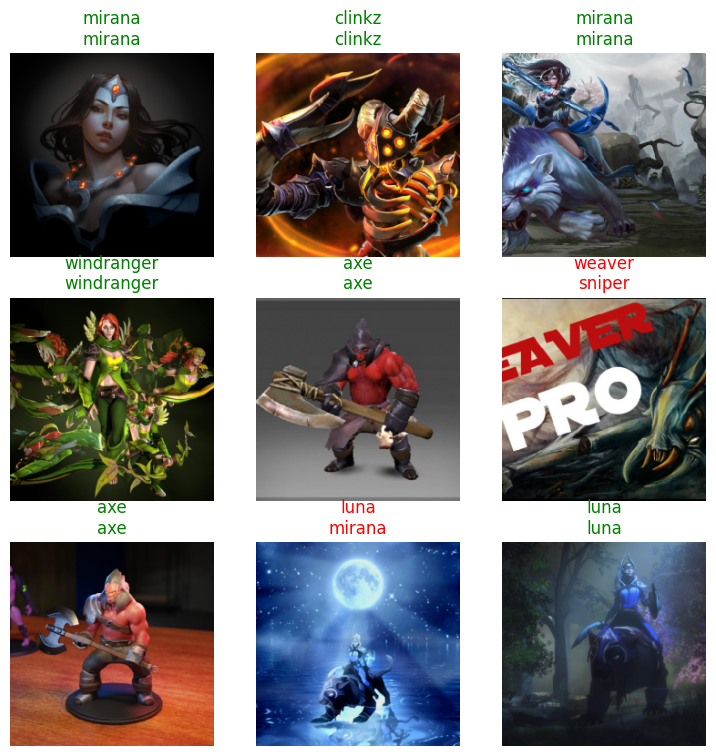

In [12]:
learn.show_results()

### Модель обучилась, теперь мы можем делать predictions

In [48]:
axe,_,probs  = learn.predict(PILImage.create('validate/axe.jpeg'))
pudge,_,probs  = learn.predict(PILImage.create('validate/pudge.jpeg'))
zeus,_,probs  = learn.predict(PILImage.create('validate/zeus.jpeg'))

print('Axe classification:', axe)
print('Pudge classification: ', pudge)
print('Zeus classification: ', zeus)

Axe:  axe
Pudge:  pudge
Zeus:  zeus
